In [2]:
from scipy.io import loadmat

mat_data = loadmat('Data/ActiveTouch/ActiveTouchWaves-GoTrials.mat')
print(mat_data.keys())
trialdata = mat_data['TW']
print(trialdata)


dict_keys(['__header__', '__version__', '__globals__', 'TW'])


[[(array([[(array([[array([[array([[0.73790444, 0.60572915, 0.72706202, 0.55470265, 0.76383567,
        0.56507131, 0.62559072, 0.81216702, 0.72449944, 0.60342048]]),
        array([[0.51566997, 0.67811156, 0.67532596, 0.55236936, 0.60981465,
        0.62535872, 0.52784732, 0.52121033]]),
        array([[0.51702801, 0.59216657, 0.61277718, 0.64978103, 0.85154825,
        0.86516815, 0.54124325, 0.66474966, 0.53394176, 0.52828077,
        0.52167078, 0.61776364]]),
        array([[0.56950955, 0.76733505, 0.55553747, 0.61181037, 0.74744456,
        0.63701315, 0.66587543, 0.65163901, 0.5252085 , 0.71151423]]),
        array([[0.63722188, 0.67246303, 0.55987151, 0.55166862, 0.61982365,
        0.52741008, 0.69791183, 0.58557919, 0.67048074, 0.63200277]]),
        array([[0.57802568, 0.65746517, 0.55698372, 0.66066365, 0.64311906,
        0.51622733, 0.72468921, 0.69568631]]),
        array([[0.68452884, 0.55109973, 0.59481959, 0.57681838, 0.52976536,
        0.52284487]]),
        array([

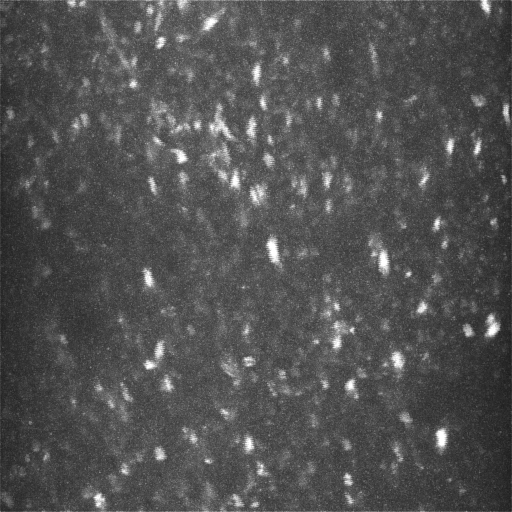

In [5]:
from PIL import Image

img = Image.open('Data/L5 Imaging/2022-08-09_DendriteImaging/FOV1-apical/imaging/Max-MeanFilter.tif')
img


dict_keys(['__header__', '__version__', '__globals__', 'calciumOnsetAnalysis'])


KeyError: 'lateSpikeEnsemble'

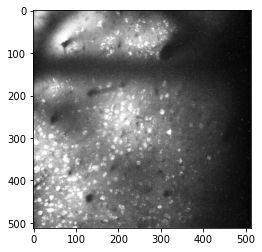

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import imageio
from scipy.io import loadmat

#%% Load the data

# Load the Caiman pipeline data
# (Assumes that the .mat file contains variables like ROI and badComponents.)
caiman_data = loadmat('Data/L2-3 Imaging/2022-09-22_Grids-Imaging/FOV1-225um/imaging/CaimanPipeline.mat')

# For example, if ROI and badComponents are stored in the mat file:
ROI = caiman_data['ROI']         # This might be a numpy object array, adjust as needed.
badComponents = caiman_data['badComponents'].flatten()  # adjust shape if necessary

# Load the TIFF image (for grid overlay)
maxtiff = imageio.imread('Data/L2-3 Imaging/2022-09-22_Grids-Imaging/FOV1-225um/imaging/MAX_2022-09-22_FOV1-225um.tif')

#%% Plot the background image

fig, ax = plt.subplots()
ax.imshow(maxtiff, cmap='gray')  # Adjust colormap if needed

#%% Load the ensemble analysis data

ensemble_data = loadmat('Data/L2-3 Imaging/2022-09-22_Grids-Imaging/FOV1-225um/ephys/Grid-LFP-DS.mat')
print(ensemble_data.keys())

# Here we assume that ensemble_data contains 'lateSpikeEnsemble' and 'nolateSpikeEnsemble'
lateSpikeEnsemble = ensemble_data['lateSpikeEnsemble']
nolateSpikeEnsemble = ensemble_data['nolateSpikeEnsemble']

# MATLAB cell arrays load as numpy arrays with dtype=object.
# To combine the rank ensembles from three cells, we extract each element.
# (You might need to adjust indexing depending on the structure of these arrays.)

def combine_rank_ensembles(ensemble):
    # Assume ensemble['rankEnsembles'] is stored as a numpy array of objects
    # and that each entry is a 2D array (or list) of indices.
    # The following code concatenates the three entries along the first axis.
    rankEnsembles = ensemble['rankEnsembles'][0,0]  # adjust field extraction as needed
    combined = np.concatenate((
        np.atleast_1d(rankEnsembles[0, 0]).flatten(),
        np.atleast_1d(rankEnsembles[0, 1]).flatten(),
        np.atleast_1d(rankEnsembles[0, 2]).flatten()
    ))
    return combined

# Extract rank indices. (MATLAB indices are 1-indexed; if needed, subtract 1 for Python indexing.)
lsRank = combine_rank_ensembles(lateSpikeEnsemble)
nlsRank = combine_rank_ensembles(nolateSpikeEnsemble)

# If your indices are 1-indexed in MATLAB and you wish to use them to index Python lists,
# you might want to subtract 1:
# lsRank = lsRank - 1
# nlsRank = nlsRank - 1

#%% Remove ROIs corresponding to bad components
# Assuming ROI is a list or array of ROIs (each ROI can be a list of contour points)
# and badComponents is an array of indices.
# Convert ROI to a list if it isn’t one already.
if not isinstance(ROI, list):
    ROI = ROI.tolist()

# Remove bad components. (If badComponents is an array of indices)
# Again, check for 0-indexing vs. 1-indexing!
ROI_clean = [roi for i, roi in enumerate(ROI) if i not in badComponents]

#%% Plot ROIs that are NOT associated with any ensemble
# Here we remove ROIs whose index is listed in lsRank or nlsRank.
# Note: be sure that the indices in lsRank/nlsRank correspond to the indices in ROI_clean.
ensemble_indices = set(np.concatenate((lsRank, nlsRank)))
ROI_all = [roi for i, roi in enumerate(ROI_clean) if i not in ensemble_indices]

for roi in ROI_all:
    # Each 'roi' is assumed to be a list (or iterable) of points.
    # Each point is assumed to be an iterable with at least 2 elements [x, y].
    x = []
    y = []
    # If roi itself is a list of points:
    for point in roi:
        x.append(point[0])
        y.append(point[1])
    # Fill the polygon with a grey color.
    ax.fill(x, y, color=[0.5, 0.5, 0.5], edgecolor='none', alpha=1.0)

#%% Plot ROIs corresponding to the late-spike ensembles in red

for cellNum in lsRank:
    # If MATLAB indices were 1-indexed, subtract 1 if necessary:
    # cellNum = cellNum - 1
    roi = ROI_clean[int(cellNum)]
    x = []
    y = []
    for point in roi:
        x.append(point[0])
        y.append(point[1])
    ax.fill(x, y, color='red', edgecolor='none', alpha=0.5)

#%% Plot ROIs corresponding to the non-late-spike ensembles in blue

for cellNum in nlsRank:
    # Adjust for 0-indexing if necessary:
    # cellNum = cellNum - 1
    roi = ROI_clean[int(cellNum)]
    x = []
    y = []
    for point in roi:
        x.append(point[0])
        y.append(point[1])
    ax.fill(x, y, color='blue', edgecolor='none', alpha=0.5)

#%% Final plot adjustments
ax.set_axis_off()  # optionally turn off the axis
plt.show()


In [10]:
#on the hunt 4 lateSpikeEnsemble and nolateSpikeEnsemble data
ensemble_data = loadmat('Data/L2-3 Imaging/2022-08-23_Grids-Imaging/FOV1-225um/ephys/onsetAnalysis.mat')
print(ensemble_data.keys())


dict_keys(['__header__', '__version__', '__globals__', 'onsetAnalysis'])


# Functions to transfer matlab into dicts

In [1]:
import numpy as np
from scipy.io import loadmat

def loadmat_recursive(filename):
    """
    Loads a MATLAB .mat file and recursively converts all mat_struct objects 
    to nested dictionaries.
    """
    data = loadmat(filename, struct_as_record=False, squeeze_me=True)
    return _check_keys(data)

def _check_keys(dict_data):
    """
    Checks if entries in the dictionary are mat_struct objects.
    If yes, _todict is called to convert them.
    """
    for key in dict_data:
        if isinstance(dict_data[key], np.ndarray):
            dict_data[key] = _tolist(dict_data[key])
        elif hasattr(dict_data[key], '_fieldnames'):
            dict_data[key] = _todict(dict_data[key])
    return dict_data

def _todict(matobj):
    """
    A recursive function which constructs nested dictionaries from mat_structs.
    """
    d = {}
    for field in matobj._fieldnames:
        elem = getattr(matobj, field)
        if isinstance(elem, np.ndarray):
            d[field] = _tolist(elem)
        elif hasattr(elem, '_fieldnames'):
            d[field] = _todict(elem)
        else:
            d[field] = elem
    return d

def _tolist(ndarray):
    """
    A recursive function which converts an ndarray into a list.
    It will also convert any mat_struct objects within the array.
    """
    elem_list = []
    if ndarray.dtype == np.object_:
        for sub_elem in ndarray:
            if hasattr(sub_elem, '_fieldnames'):
                elem_list.append(_todict(sub_elem))
            elif isinstance(sub_elem, np.ndarray):
                elem_list.append(_tolist(sub_elem))
            else:
                elem_list.append(sub_elem)
        return elem_list
    else:
        # For numeric arrays, return as is (or you can call ndarray.tolist() if desired)
        return ndarray


# Fig_RepresentativeTrial

<class 'dict'>
<class 'dict'>
Type of trialDf['Neuron1']: <class 'numpy.ndarray'>
252


/opt/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:95: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


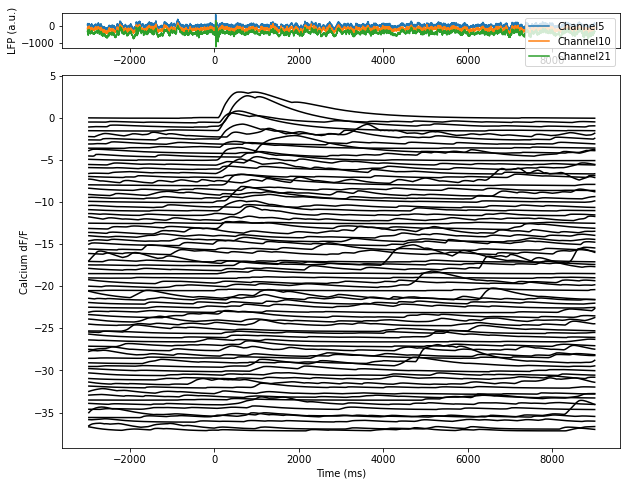

In [10]:
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt

# Load and convert the file
data = loadmat_recursive(r'Data/L2-3 Imaging/2022-08-23_Grids-Imaging/FOV1-225um/imaging/trialDf.mat')
print(type(data))
#252 neuron array
trialDf = data['trialDf']
trialdDf = data['trialdDf']

# Similarly, load ephys LFP data
data2 = loadmat_recursive(r'Data/L2-3 Imaging/2022-08-23_Grids-Imaging/FOV1-225um/ephys/Grid-LFP-DS.mat')
print(type(data2))

lowpassBand = data2['lowpassBand']

# List keys in trialDf (should include 'Neuron1', 'Neuron2', etc.)
#print("TrialDf keys:", list(trialDf.keys()))

# Check the type of one neuron entry:
first_neuron = trialDf['Neuron1']
print("Type of trialDf['Neuron1']:", type(first_neuron))

repTrial = 40  # MATLAB trial number (remember to subtract 1 for Python indexing if needed)
Fr = 30

num_neurons = len(trialDf)  # should be 252 in your case
print(len(trialDf))

maxCaResponse = []
for nn in range(1, num_neurons + 1):
    key = 'Neuron' + str(nn)
    # Get deconvoluted trace from trialdDf for this neuron and trial (subtract 1 for Python indexing)
    dFoverF = trialdDf[key][repTrial - 1, :]
    # Extract the window [3*Fr:4*Fr] and compute the maximum response
    window = dFoverF[3*Fr : 4*Fr]
    maxCaResponse.append(np.max(window))
maxCaResponse = np.array(maxCaResponse)

# Get sorted indices in descending order.
# IMPORTANT: Our maxCaResponse list is 0-indexed where index 0 corresponds to Neuron1.
sortedIdx = np.argsort(-maxCaResponse)  # sorted indices (0-indexed)
# When later accessing a neuron, use: "Neuron" + str(sortedIdx[i] + 1)

# =============================================================================
# %% Plot ephys + calcium trials for top 75 cells
# =============================================================================
#
# Create a figure with two panels:
#  - Top (subplot 411) for ephys (LFP) traces.
#  - Bottom (subplot 4,1,[2 3 4]) for the top 75 calcium traces (raw), vertically shifted.
#
# Create figure and axes
fig1 = plt.figure(figsize=(10, 8))
gs = gridspec.GridSpec(4, 1, height_ratios=[1, 3, 3, 3], hspace=0.3)
ax1 = fig1.add_subplot(gs[0, 0])
ax2 = fig1.add_subplot(gs[1:4, 0], sharex=ax1)

# --- Top panel: Plot ephys traces
# Create time vector for LFP data:
n_points = lowpassBand['Channel5'].shape[1]
t_ephys = (np.arange(1, n_points+1) / 2500 * 1000) - 3000  # similar to MATLAB's 1:number_points
# Plot three channels, adjusting vertical offsets:
ax1.plot(t_ephys, lowpassBand['Channel5'][repTrial - 1, :], label='Channel5')
ax1.plot(t_ephys, lowpassBand['Channel10'][repTrial - 1, :] - 200, label='Channel10')
ax1.plot(t_ephys, lowpassBand['Channel21'][repTrial - 1, :] - 400, label='Channel21')
ax1.set_ylabel('LFP (a.u.)')
ax1.legend(loc='upper right')

# --- Bottom panel: Plot calcium traces for top 75 cells
# Create time vector for calcium data:
n_timepoints = trialDf['Neuron1'].shape[1]
t_calcium = (np.arange(1, n_timepoints+1) / Fr * 1000) - 3000

y_offset = 0
# Preallocate a list to store baseline-corrected traces if desired
df_list = []

# Plot top 75 neurons (or fewer if there are less than 75)
top_n = min(75, num_neurons)
for i in range(top_n):
    # sortedIdx[i] is 0-indexed and corresponds to Neuron{sortedIdx[i]+1}
    neuron_key = 'Neuron' + str(sortedIdx[i] + 1)
    d = trialDf[neuron_key][repTrial - 1, :].copy()
    # Subtract baseline computed over the first 3*Fr timepoints
    baseline = np.mean(d[:3*Fr])
    d = d - baseline
    df_list.append(d)
    # Plot trace with a vertical offset (increasing offset so traces don’t overlap)
    ax2.plot(t_calcium, d - y_offset, color='black')
    y_offset += 0.5

ax2.set_ylabel('Calcium dF/F')
ax2.set_xlabel('Time (ms)')
plt.tight_layout()
plt.show()




/opt/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:40: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


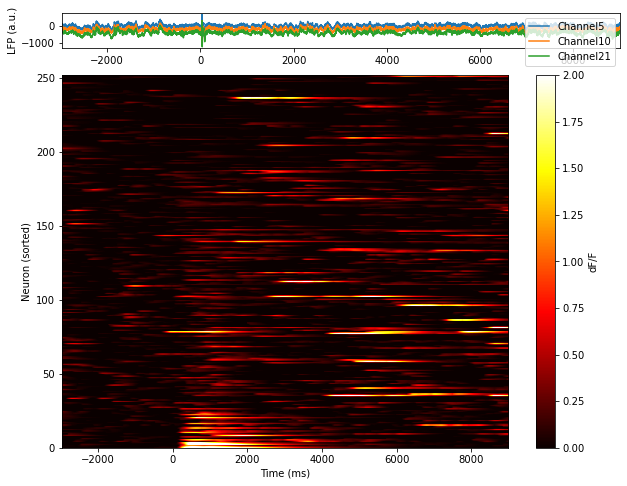

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# --- Create a figure with two panels using GridSpec ---
fig2 = plt.figure(figsize=(10, 8))
gs2 = gridspec.GridSpec(4, 1, height_ratios=[1, 3, 3, 3], hspace=0.3)
ax21 = fig2.add_subplot(gs2[0, 0])
ax22 = fig2.add_subplot(gs2[1:4, 0], sharex=ax21)

# --- Top panel: Plot ephys traces ---
ax21.plot(t_ephys, lowpassBand['Channel5'][repTrial - 1, :], label='Channel5')
ax21.plot(t_ephys, lowpassBand['Channel10'][repTrial - 1, :] - 200, label='Channel10')
ax21.plot(t_ephys, lowpassBand['Channel21'][repTrial - 1, :] - 400, label='Channel21')
ax21.set_ylabel('LFP (a.u.)')
ax21.legend(loc='upper right')

# --- Bottom panel: Build the heatmap of calcium traces ---
df_all = []
for i in range(num_neurons):
    # sortedIdx[i] is 0-indexed; add 1 when forming the key.
    neuron_key = 'Neuron' + str(sortedIdx[i] + 1)
    d = trialDf[neuron_key][repTrial - 1, :].copy()
    baseline = np.mean(d[:3 * Fr])
    d = d - baseline
    df_all.append(d)
df_all = np.array(df_all)

# Flip the array vertically (to mimic MATLAB's flipud)
df_all_flipped = np.flipud(df_all)

# Plot the heatmap with imshow
im = ax22.imshow(df_all_flipped, aspect='auto',
                 extent=[t_calcium[0], t_calcium[-1], 0, df_all_flipped.shape[0]],
                 cmap='hot', vmin=0, vmax=2)
ax22.set_ylabel('Neuron (sorted)')
ax22.set_xlabel('Time (ms)')
plt.colorbar(im, ax=ax22, label='dF/F')

plt.tight_layout()
plt.show()


/opt/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:38: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


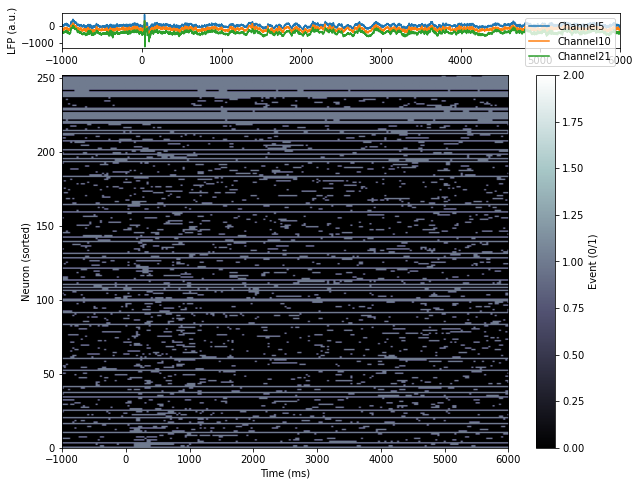

In [12]:

# --- Create a new figure with two panels using GridSpec ---
fig3 = plt.figure(figsize=(10, 8))
gs3 = gridspec.GridSpec(4, 1, height_ratios=[1, 3, 3, 3], hspace=0.3)
ax31 = fig3.add_subplot(gs3[0, 0])
ax32 = fig3.add_subplot(gs3[1:4, 0], sharex=ax31)

# --- Top panel: Plot ephys traces (same as before) ---
ax31.plot(t_ephys, lowpassBand['Channel5'][repTrial - 1, :], label='Channel5')
ax31.plot(t_ephys, lowpassBand['Channel10'][repTrial - 1, :] - 200, label='Channel10')
ax31.plot(t_ephys, lowpassBand['Channel21'][repTrial - 1, :] - 400, label='Channel21')
ax31.set_ylabel('LFP (a.u.)')
ax31.legend(loc='upper right')

# --- Bottom panel: Build the binarized calcium events heatmap ---
ddf_list = []
for i in range(num_neurons):
    neuron_key = 'Neuron' + str(sortedIdx[i] + 1)
    d = trialdDf[neuron_key][repTrial - 1, :].copy()
    # Compute the threshold at the 90th percentile
    thresh = np.percentile(d, 90)
    # Binarize: values below threshold become 0, values above become 1
    d_binary = np.where(d < thresh, 0, 1)
    ddf_list.append(d_binary)
ddf = np.array(ddf_list)
ddf_flipped = np.flipud(ddf)

im2 = ax32.imshow(ddf_flipped, aspect='auto',
                  extent=[t_calcium[0], t_calcium[-1], 0, ddf_flipped.shape[0]],
                  cmap='bone', vmin=0, vmax=2)
ax32.set_ylabel('Neuron (sorted)')
ax32.set_xlabel('Time (ms)')
plt.colorbar(im2, ax=ax32, label='Event (0/1)')

# Link the x-axes and adjust limits:
ax31.set_xlim([-1000, 6000])
ax32.set_xlim([-1000, 6000])

plt.tight_layout()
plt.show()


# Fig1_LFP_Latency

In [14]:
from scipy.stats import zscore
from scipy.ndimage import gaussian_filter1d  # for smoothing
#import cv2  # for video writing

# === Helper Functions (you must implement or replace these) ===

def inpaint_nans(arr):
    """
    Dummy inpaint_nans: replace NaNs with nearest non-NaN value along each row.
    A proper implementation might use interpolation.
    """
    # For each row, replace NaNs by linear interpolation
    out = np.copy(arr)
    for i in range(arr.shape[0]):
        row = arr[i, :]
        nans = np.isnan(row)
        if np.any(~nans):
            x = np.arange(len(row))
            out[i, nans] = np.interp(x[nans], x[~nans], row[~nans])
    return out

def GP_analysis_Pipeline(bandCube, parameters, start_time, stop_time, X, Y):
    """
    Dummy implementation.
    Replace with your actual processing function.
    Returns a tuple of outputs.
    """
    # For example purposes, create dummy outputs.
    # xgp shape: (8,4, number_of_time_points)
    n_time = bandCube.shape[2]
    xgp = np.exp(1j*np.random.rand(8,4,n_time)*2*np.pi)
    evaluation_points = None
    rho = None
    speed = None
    phaseMaps = None
    sourcePoints = None
    dist = None
    phaseDist = None
    amplitudeY = None
    amplitudeX = None
    amplitudeLoc = None
    return (xgp, evaluation_points, rho, speed, phaseMaps, sourcePoints, dist, phaseDist, amplitudeY, amplitudeX, amplitudeLoc)

def smoothn(data, sigma=1):
    """
    Smooth a 2D array using a Gaussian filter.
    """
    return gaussian_filter1d(data, sigma=sigma, axis=0)

def customcolormap_preset(name):
    """
    Return a matplotlib colormap. For example, if name=='pasteljet'
    you can return a colormap from Matplotlib.
    """
    # Here we use 'jet' as a placeholder.
    return plt.get_cmap('jet')

def smooth(data, window_size):
    """
    Simple 1D smoothing using a moving average.
    window_size is in number of samples.
    """
    window = int(np.round(window_size))
    if window < 1:
        return data
    return np.convolve(data, np.ones(window)/window, mode='same')

# === Load Data ===
# Load LFP data and badChannels from your MAT files
lfp_data = loadmat_recursive(r'Data/L2-3 Imaging/2022-09-22_Grids-Imaging/FOV1-225um/ephys/Grid-LFP-DS.mat')
bad_channels_data = loadmat_recursive(r'Data/L2-3 Imaging/2022-09-22_Grids-Imaging/FOV1-225um/ephys/badChannels.mat')

lowpassBand = lfp_data['lowpassBand']
badChannels = bad_channels_data['badChannels']  # Assume this is an array/list of bad channel numbers

# === Define Grid Mappings ===
gridMapping = np.array([15,  0, 16, 31,
                        1, 14, 30, 17,
                        2, 13, 29, 18,
                        3, 12, 28, 19,
                        4, 11, 27, 20,
                        5, 10, 26, 21,
                        6,  9, 25, 22,
                        7,  8, 24, 23]) + 1

# gridMapping2 as an 8x4 matrix:
gridMapping2 = np.array([[15,  0, 16, 31],
                         [1, 14, 30, 17],
                         [2, 13, 29, 18],
                         [3, 12, 28, 19],
                         [4, 11, 27, 20],
                         [5, 10, 26, 21],
                         [6,  9, 25, 22],
                         [7,  8, 24, 23]]) + 1

# === Define Parameters ===
parameters = {}
parameters['Fs'] = 2500  # sampling rate in Hz
parameters['filter_order'] = 4
parameters['f'] = [3, 40]  # filter band
parameters['start_time'] = -300  # ms
parameters['stop_time'] = 0    # ms
parameters['pixel_spacing'] = 0.120  # mm
parameters['lp'] = 0  # cutoff for negative frequency detection [Hz]
parameters['evaluation_angle'] = -np.pi/2
parameters['tol'] = 0.2

Fs = parameters['Fs']

# === Create Grid (for plotting later) ===
# X and Y are 2D arrays representing the grid indices.
X, Y = np.meshgrid(np.arange(1, 5), np.arange(1, 9))  # 4 columns, 8 rows

start_time_idx = 1
stop_time_idx = int(round(1.000 * Fs))

# === Phase Across Grid ===
# Define tt as time indices 30:50 (MATLAB inclusive; Python: 30 to 50 inclusive)
tt = np.arange(30, 51)

# Create bandCube: an array of shape (8, 4, n_timepoints)
n_timepoints = lowpassBand['Channel1'].shape[1]
bandCube = np.full((8, 4, n_timepoints), np.nan)

i = 0
# Loop over channels 1 to 32
for cc in range(1, 33):
    # If cc is not in badChannels (assume badChannels is a 1D array of numbers)
    if cc not in badChannels:
        # Find (r, c) such that gridMapping2[r,c] equals cc.
        # Note: gridMapping2 is 8x4.
        pos = np.where(gridMapping2 == cc)
        if pos[0].size > 0:
            r = pos[0][0]  # row index
            c = pos[1][0]  # column index
            i += 1
            # Get average trace b from lowpassBand for channel cc, averaged over rows tt.
            # Build the key name as in MATLAB: 'Channel' + str(cc)
            key = 'Channel' + str(cc)
            # Average over the time indices in tt (assume these are row indices)
            b = np.mean(lowpassBand[key][tt, :], axis=0)
            bandCube[r, c, :] = b

# Inpaint NaNs for each time slice of bandCube.
for ii in range(bandCube.shape[2]):
    bandCube[:, :, ii] = inpaint_nans(bandCube[:, :, ii])

# === Run TW (Traveling Wave) Analysis via GP_analysis_Pipeline ===
# This function is assumed to be implemented in Python.
(xgp, evaluation_points, rho, speed, phaseMaps, sourcePoints, dist, 
 phaseDist, amplitudeY, amplitudeX, amplitudeLoc) = GP_analysis_Pipeline(bandCube, parameters, start_time_idx, stop_time_idx, X, Y)

# Define a window: round(3.024*Fs) to round(3.028*Fs)
window_start = int(round(3.024 * Fs))
window_stop  = int(round(3.028 * Fs))
window = np.arange(window_start, window_stop+1)  # inclusive of stop if desired

# Compute phase p: angle of the mean of xgp across the window (axis=2)
p = np.angle(np.mean(xgp[:, :, window], axis=2))

# Smooth the phase using smoothn
m = smoothn(p, sigma=1)

# Plot the smoothed phase map
plt.figure()
plt.imshow(m, aspect='auto', origin='upper')
# Use custom colormap; here we use the preset function.
J = customcolormap_preset('pasteljet')
plt.set_cmap(J)
plt.title('Smoothed Phase Map')
plt.colorbar(label='Phase (radians)')
plt.show()

# === Plot the traces across a single column to see the propagation ===
plt.figure()
plt.title('Propagation in a Single Column')
y_offset = 0
i = 0
# Define a list of channels (MATLAB: [26 25 27 28 29 30 31 17])
channels_to_plot = [26, 25, 27, 28, 29, 30, 31, 17]
# Create a time vector for LFP
t = np.arange(1, lowpassBand['Channel1'].shape[1]+1) / Fs * 1000 - 3000  # in ms

for cc in channels_to_plot:
    i += 1
    key = 'Channel' + str(cc)
    # Compute mean across rows tt and then zscore the resulting trace.
    trace = np.mean(lowpassBand[key][tt, :], axis=0)
    data = zscore(trace)
    # Smooth the data; window size = 0.010*2500 samples
    data = smooth(data, window_size=0.010 * 2500)
    # Find the minimum between indices 7580 and 7600 (MATLAB uses min)
    segment = data[7580:7600]
    maxV = np.min(segment)  # minimum value
    maxIdx = np.argmin(segment) + 7580  # adjust index offset
    plt.plot(t, data - y_offset, label=f'Channel {cc}')
    plt.plot(t[maxIdx], maxV - y_offset, 'r.')
    y_offset += 7  # vertical offset for next trace

plt.xlabel('Time (ms)')
plt.ylabel('Z-scored & Offset Signal')
plt.title('Propagation Across a Column')
plt.legend()
plt.show()

# === Plot LFP time points and create a video ===
# Compute LFP traces for each channel over tt.
tt_range = np.arange(30, 51)
# Preallocate a data array for 32 channels.
data_array = np.zeros((32, lowpassBand['Channel1'].shape[1]))
for cc in range(1, 33):
    key = 'Channel' + str(cc)
    # Special conditions for certain channels:
    if cc == 23:
        data1 = np.mean(lowpassBand['Channel' + str(24)][tt_range, :], axis=0)
        data2 = np.mean(lowpassBand['Channel' + str(22)][tt_range, :], axis=0)
        data3 = np.mean(lowpassBand['Channel' + str(26)][tt_range, :], axis=0)
        x_mean = np.mean(np.vstack([data1, data2, data3]), axis=0)
    elif cc == 9:
        data1 = np.mean(lowpassBand['Channel' + str(8)][tt_range, :], axis=0)
        data2 = np.mean(lowpassBand['Channel' + str(25)][tt_range, :], axis=0)
        x_mean = np.mean(np.vstack([data1, data2]), axis=0)
    elif cc == 10:
        data1 = np.mean(lowpassBand['Channel' + str(8)][tt_range, :], axis=0)
        data2 = np.mean(lowpassBand['Channel' + str(27)][tt_range, :], axis=0)
        data3 = np.mean(lowpassBand['Channel' + str(26)][tt_range, :], axis=0)
        x_mean = np.mean(np.vstack([data1, data2, data3]), axis=0)
    elif cc == 1:
        data1 = np.mean(lowpassBand['Channel' + str(2)][tt_range, :], axis=0)
        data2 = np.mean(lowpassBand['Channel' + str(15)][tt_range, :], axis=0)
        data3 = np.mean(lowpassBand['Channel' + str(17)][tt_range, :], axis=0)
        x_mean = np.mean(np.vstack([data1, data2, data3]), axis=0)
    else:
        x_mean = np.mean(lowpassBand['Channel' + str(cc)][tt_range, :], axis=0)
    # Smooth the resulting signal with a window of 0.010*2500 samples.
    data_array[cc-1, :] = smooth(x_mean, window_size=0.010 * 2500)

# Create a video of mapped LFP. We assume t is defined as earlier.
t_vector = np.arange(1, lowpassBand['Channel1'].shape[1]+1) / Fs * 1000 - 3000

# Determine the index closest to t==0
startIdx = np.argmin(np.abs(t_vector - 0))
# Create video writer (using OpenCV). Adjust fourcc and frame rate as needed.
video_filename = 'Mapped_LFP.avi'
fourcc = cv2.VideoWriter_fourcc(*'XVID')
fps = 2500  # number of frames per second (or adjust)
frame_size = (1920, 1080)  # adjust as needed
v_writer = cv2.VideoWriter(video_filename, fourcc, fps, frame_size)

# Create a figure for plotting (we use matplotlib to draw frames, then capture them)
fig_video = plt.figure(figsize=(19.2, 10.8))  # corresponds to 1920x1080 pixels
ax_video = plt.gca()
plt.axis('off')

# Loop over a short window (0.200 seconds of data)
n_frames = int(round(0.200 * Fs))
for i in range(startIdx, startIdx + n_frames):
    # For each time point, build an LFP vector using gridMapping.
    # gridMapping is length 32. For each cc in 1:32, get the corresponding channel value from data_array.
    lfp_vals = np.zeros(32)
    for cc in range(32):
        # gridMapping[cc] gives a channel number; subtract 1 for Python indexing.
        ch = int(gridMapping[cc])  # channel number (1-indexed)
        lfp_vals[cc] = data_array[ch-1, i]
    # Reshape lfp_vals to shape (8,4). Note that MATLAB uses a transposed layout.
    lfp_reshaped = lfp_vals.reshape(4, 8).T  # shape (8,4)
    
    # Plot the image.
    ax_video.cla()  # clear the axis
    im_frame = ax_video.imshow(lfp_reshaped, aspect='auto', cmap='parula')
    ax_video.set_xticks([])
    ax_video.set_yticks([])
    plt.clim(-400, 200)
    
    # Draw the canvas and convert to an image (RGB)
    fig_video.canvas.draw()
    frame = np.frombuffer(fig_video.canvas.tostring_rgb(), dtype=np.uint8)
    frame = frame.reshape(fig_video.canvas.get_width_height()[::-1] + (3,))
    
    # Resize frame to desired frame size if necessary
    frame = cv2.resize(frame, frame_size)
    
    # Write frame to video
    v_writer.write(frame)
    
v_writer.release()
plt.close(fig_video)

print("Video saved as", video_filename)


IndexError: index 50 is out of bounds for axis 0 with size 50